#Узнай героев сериала "Друзья" с первых слов  

##Трек по NLP фестиваля RuCode#4

В задании необходимо научиться предсказывать, кому из 6 главных героев сериала "Друзья" принадлежит реплика. В качестве данных вам будут даны скрипты сериала "Друзья" с репликами главных героев. На этих данных вам предстоит обучить классификатор, предсказывающий имя персонажа - автора реплики (задача классификации на 6 классов).

Задача: классификация текста на 6 классов (имя персонажа, сказавшего реплику). При решении задачи разрешается использовать только данные, предоставленные организаторами соревнования, использование любых дополнительных данных запрещено. при этом разрешается пользоваться предобученными моделями из открытых источников (word2vec, Bert, etc.)

In [3]:
!pip install pyunpack

In [4]:
import pandas as pd
import numpy as np
!wget --no-check-certificate --output-document example.rar https://github.com/dmitrykhrabroff/Friends/blob/main/friends-classification.zip?raw=true



from pyunpack import Archive
Archive('/content/example.rar').extractall('/content/')

--2022-03-01 06:32:49--  https://github.com/dmitrykhrabroff/Friends/blob/main/friends-classification.zip?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dmitrykhrabroff/Friends/raw/main/friends-classification.zip [following]
--2022-03-01 06:32:50--  https://github.com/dmitrykhrabroff/Friends/raw/main/friends-classification.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmitrykhrabroff/Friends/main/friends-classification.zip [following]
--2022-03-01 06:32:50--  https://raw.githubusercontent.com/dmitrykhrabroff/Friends/main/friends-classification.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

Для предобработки текстов будем использовать библиотеку от Яндекса pymystem3. Важно установить именно данную версию, потому что у новой вознакет конфликт при работе с jupyter notebook.


In [5]:
!pip install pymystem3==0.1.10

In [6]:
import pandas as pd
train_data = pd.read_csv('/content/train_data.csv')
val_data = pd.read_csv('/content/val_data.csv')
test_data = pd.read_csv('/content/test.csv')
val_data.columns= train_data.columns
train_data.shape, val_data.shape, test_data.shape

((24993, 4), (2778, 4), (3086, 3))

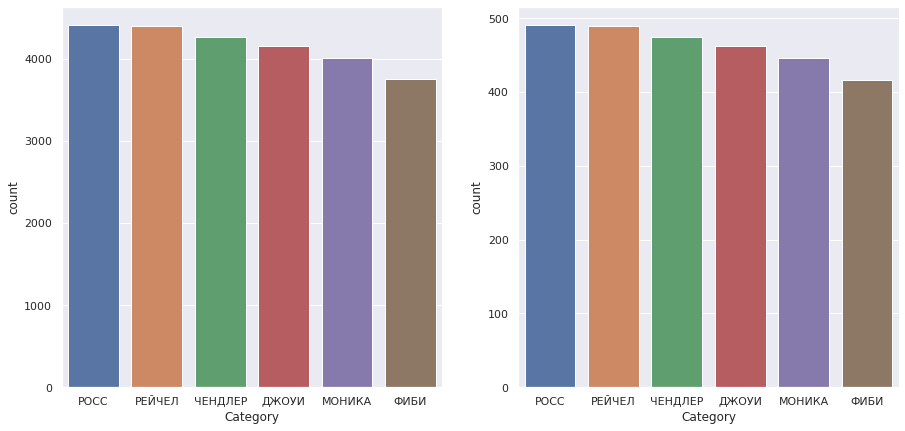

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15,7)})
fig, axes = plt.subplots(1,2)
sns.countplot(train_data.Category, ax = axes[0], order = train_data['Category'].value_counts().index)
sns.countplot(val_data.Category, ax = axes[1], order = train_data['Category'].value_counts().index)
plt.show()

Мы видим, что распределения целевого признака в тренировочном и валидационном датасете похожи, однако для проверки валидационная выборка мала, поэтому в дальнейшем мы самостоятельно разделим наш датасет на train/valid/test, а пока объединим все таблицу в одну для дальнейшей предобработки.

In [8]:
data = pd.concat((train_data,val_data, test_data)).reset_index()
data

,index,Id,other_speaker,friend_response,Category
0,0,0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",ЧЕНДЛЕР
1,1,1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",ЧЕНДЛЕР
2,2,2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",РОСС
3,3,3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",ДЖОУИ
4,4,4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",РОСС
...,...,...,...,...,...
30852,3081,3081,Дело не только в барабанах. Каждые пять минут ...,"Понимаете, именно так нормальные люди должны р...",NaN
30853,3082,3082,"Кажется, я случайно использовал коробки Моники...","Боже, все испорчено! Папа, она будет раздавлена!",NaN
30854,3083,3083,"ну знаете, вот почему через несколько лет расп...","Ой, это так здорово.",NaN
30855,3084,3084,"Он переспал с тобой, а потом никогда тебе не з...",А я просто хотела нового папу для Дэви и Бекки.,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30857 entries, 0 to 30856
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            30857 non-null  int64 
 1   Id               30857 non-null  int64 
 2   other_speaker    30856 non-null  object
 3   friend_response  30857 non-null  object
 4   Category         27771 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [10]:
data.loc[data.other_speaker.isna(),:]
data.other_speaker.fillna('',inplace = True)

Приступим к леммитизации текстов, для этого используем ранее установленную билиотеку pymystem3. Ее особенностью относительно аналогов (pymorphy2) является то, что она медленно обрабатывает единичные вызовы функции, но способна быстро обрабатывать большие объемы текста. Поэтому напишем функцию, которая предварительно объединяет все наши тексты в одну строку с характерным разделителем строки, обработаем ее с помощью pymystem3, и далее снова разделим по нашему разделителю.

In [11]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2022-03-01 06:32:59--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.245, 5.45.205.243, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-mskm901.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-03-01 06:33:00--  https://cachev2-mskm901.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm901.cdn.yandex.net (cachev2-mskm901.cdn.yandex.net)... 5.45.220.90, 2a02:6b8:0:2002::990
Connecting to cachev2-mskm901.cdn.yandex.net (cachev2-mskm901.cdn.yandex.net)|5.45.220.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-3.0-linu

In [10]:
from pymystem3 import Mystem
import re
def mystem_lemmatize(data, column, new_column):
    text = ' mityaich '.join(data[column].to_list())
    text = ' '.join(re.compile(r'[А-Яа-яA-Za-z\-]+').findall(text))
    data[new_column] = ''
    m = Mystem()
    lemmas_text = ' '.join(m.lemmatize(text))
    data[new_column] = lemmas_text.split('mityaich')
    return data

In [11]:
data = mystem_lemmatize(data, 'friend_response', 'lemmas_freind_response')
data = mystem_lemmatize(data, 'other_speaker', 'lemmas_other_speaker')
data

,index,Id,other_speaker,friend_response,Category,lemmas_freind_response,lemmas_other_speaker
0,0,0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",ЧЕНДЛЕР,знать я думать ты смочь она забира...,хорошо все в порядок достаточно дост...
1,1,1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",ЧЕНДЛЕР,эй знать что если ты собираться ...,о хотеть добрый имя идти с джоу...
2,2,2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",РОСС,как я уже сказать я подумывать ...,боже мой что
3,3,3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",ДЖОУИ,эй но хоть ты получать этот кру...,беременность тяжело сказываться на ...
4,4,4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",РОСС,ладно послушать вчера я бы даже ...,ладно нет этот неправильный решение...
...,...,...,...,...,...,...,...
30852,3081,3081,Дело не только в барабанах. Каждые пять минут ...,"Понимаете, именно так нормальные люди должны р...",NaN,понимать именно так нормальный чело...,дело не только в барабан каждый ...
30853,3082,3082,"Кажется, я случайно использовал коробки Моники...","Боже, все испорчено! Папа, она будет раздавлена!",NaN,боже все испортить папа она быть ...,кажется я случайно использовать кор...
30854,3083,3083,"ну знаете, вот почему через несколько лет расп...","Ой, это так здорово.",NaN,ой это так здорово,ну знать вот почему через несколь...
30855,3084,3084,"Он переспал с тобой, а потом никогда тебе не з...",А я просто хотела нового папу для Дэви и Бекки.,NaN,а я просто хотеть новый папа дл...,он переспать с ты а потом никог...


##SGDCLassifier

Создадим первую baseline модель, построим линейную регрессию к нашим леммитизированным данным. Разделим данные на тренировочные, валидационные и тестовые по индексу, так будет удобнее к ним обращаться после дальнейших обработок текста. Получим взвешенное векторное представление каждой фразы с помощью TfidfVectorizer. В первончальном варианте удалять стоп-слова не будем. В качестве классификатора будем использовать линейную модель SGDClassifier с кросс-валидацией и подбором параметров через GridSearch

In [12]:
from sklearn.model_selection import train_test_split
test_idx = data['Category'].isna()
y = data.loc[data['Category'].notnull(),'Category']
train_idx, val_idx, y_train, y_val = train_test_split(list(range(y.shape[0])),y ,test_size = 0.25, stratify = y)
len(train_idx), len(val_idx), y_train.shape, y_val.shape

(20828, 6943, (20828,), (6943,))

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

new_texts = data.loc[train_idx,'lemmas_freind_response']
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(new_texts)

sgd = SGDClassifier(random_state = 0, tol=1e-3)
parameters_grid = {'alpha' : np.linspace(0.000001, 0.00001, 5),
      'eta0' : np.linspace(0.000001, 0.00001, 5),
    'max_iter' : np.arange(5,10),
}

cv = StratifiedShuffleSplit(n_splits=3, test_size = 0.3)

grid = GridSearchCV(estimator=sgd, param_grid=parameters_grid, cv = cv)
grid.fit(vectors, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.3,
            train_size=None),
             estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': array([1.00e-06, 3.25e-06, 5.50e-06, 7.75e-06, 1.00e-05]),
                         'eta0': array([1.00e-06, 3.25e-06, 5.50e-06, 7.75e-06, 1.00e-05]),
                         'max_iter': array([5, 6, 7, 8, 9])})
0.2520936683202646
SGDClassifier(alpha=1e-05, eta0=1e-06, max_iter=5, random_state=0)


In [ ]:
from sklearn.metrics import accuracy_score
prediction = grid.best_estimator_.predict(vectorizer.transform(data.loc[val_idx,'lemmas_freind_response']))
score = accuracy_score(prediction, y_val)
score

0.25046809736425174

Попробуем посмотреть какие слова чаще характерны для каждого персонажа.

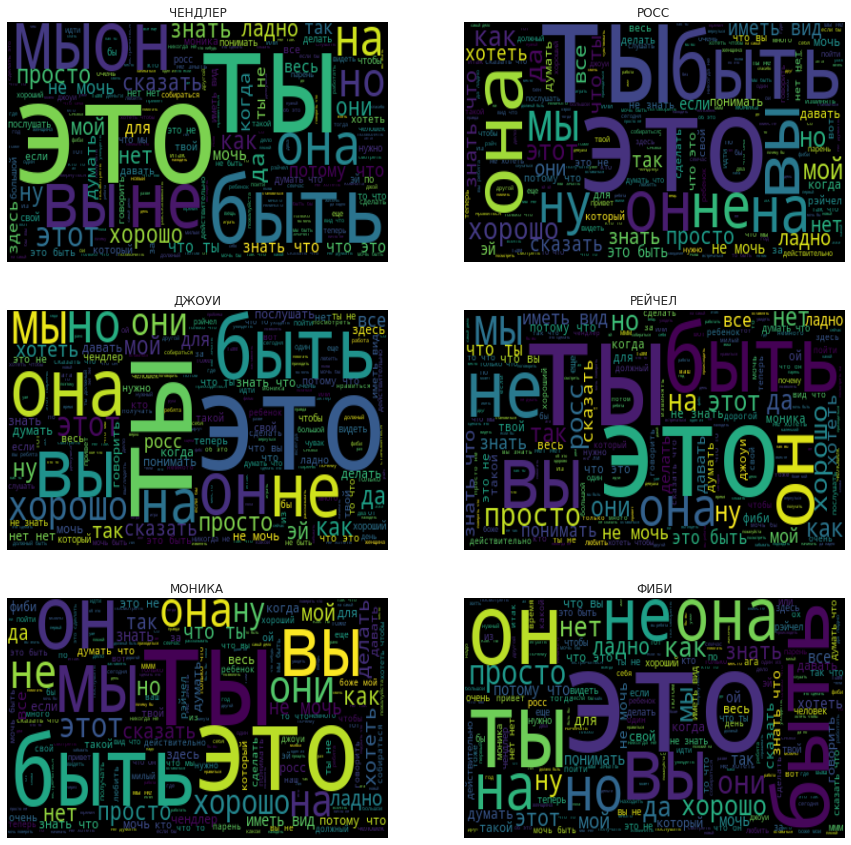

In [ ]:
from wordcloud import WordCloud
%matplotlib inline
fig, axes = plt.subplots(3,2, figsize = (15,15))
for i,name in enumerate(data.Category.dropna().unique()):
    text_raw = ' '.join(data.loc[train_idx,:].loc[data.loc[:,'Category'] == name, 'lemmas_freind_response'].to_list())
    wordcloud = WordCloud().generate(text_raw)
    axes[i//2, i % 2].imshow(wordcloud, aspect='auto', interpolation="bilinear")
    axes[i//2, i % 2].axis('off')
    axes[i//2, i % 2].set_title(name);

Мы видим что ключевые слова для всех персонажей очень похожи. Удаление стоп-слов только ухудшает результаты модели, видимо потому что мы имеем дело с разговорным текстом, и тут гораздо полезнее будет исследовать сочетание слов в предложении (ngram). Удалим непопулярные слова которые встречались в тексте только 1 раз, потому что скорее всего они не дадут нам никакой полезной информации, а уменьшение размерности матрицы существенно снизит вычислительную сложность модели.

In [ ]:
1/data.loc[train_idx, :].shape[0]

4.801229114653351e-05

In [ ]:
def find_non_popular_words(data, n = 5e-5):
    vectorizer = TfidfVectorizer(max_df=0.00005)
    vectorizer.fit_transform(new_texts)
    non_popular_words = set(vectorizer.get_feature_names())
    return non_popular_words

def tf_idf_vetorize(data, col, train_idx, val_idx,stop_words, ngram_range = (1,4)):
    new_texts = data.loc[train_idx,col]
    val_texts = data.loc[val_idx,col]
    vectorizer = TfidfVectorizer(stop_words = non_popular_words, ngram_range = ngram_range)
    vectors = vectorizer.fit_transform(new_texts)
    val_vectors = vectorizer.transform(val_texts)
    return vectors, val_vectors

def learn_SGDClassifier(X_train, y_train, parameters_grid, loss = 'modified_huber'):
    sgd = SGDClassifier(random_state = 0, tol=1e-3)
    cv = StratifiedShuffleSplit(n_splits=3, test_size = 0.3)
    grid = GridSearchCV(estimator=sgd, param_grid=parameters_grid, cv = cv)
    grid.fit(X_train, y_train)
    print(grid)
    # summarize the results of the grid search
    print(grid.best_score_)
    print(grid.best_params_)
    return grid.best_estimator_

def evaluate_SGD(model, X_val, y_val):
    prediction = model.predict(X_val)
    score = accuracy_score(prediction, y_val)
    return score

In [ ]:
non_popular_words = find_non_popular_words(data.loc[train_idx, 'lemmas_freind_response'])
X_train, X_val = tf_idf_vetorize(data, 'lemmas_freind_response', train_idx, val_idx, non_popular_words)
parameters_grid = {'alpha' : np.linspace(0.000001, 0.0001, 5),
          'eta0' : np.linspace(0.0000001, 0.00001, 5),
        'max_iter' : np.arange(5,10),
    }
model = learn_SGDClassifier(X_train, y_train, parameters_grid)
evaluate_SGD(model, X_val, y_val)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.3,
            train_size=None),
             estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': array([1.000e-06, 2.575e-05, 5.050e-05, 7.525e-05, 1.000e-04]),
                         'eta0': array([1.000e-07, 2.575e-06, 5.050e-06, 7.525e-06, 1.000e-05]),
                         'max_iter': array([5, 6, 7, 8, 9])})
0.26916306609057444
{'alpha': 0.0001, 'eta0': 1e-07, 'max_iter': 8}


0.27293677084833645

Мы получили достаточно неплохие результаты идля такой простой модели, при том что мы не включали в модель реплику other_speaker, поэтому попробуем обучить вторую модель на основании 

In [ ]:
non_popular_words = find_non_popular_words(data.loc[train_idx, 'lemmas_other_speaker'])
X_train, X_val = tf_idf_vetorize(data,'lemmas_other_speaker', train_idx, val_idx, non_popular_words)
parameters_grid = {'alpha' : np.linspace(0.000001, 0.0001, 5),
          'eta0' : np.linspace(0.0000001, 0.00001, 5),
        'max_iter' : np.arange(5,10),
    }
model = learn_SGDClassifier(X_train, y_train, parameters_grid)
evaluate_SGD(model, X_val, y_val)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.3,
            train_size=None),
             estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': array([1.000e-06, 2.575e-05, 5.050e-05, 7.525e-05, 1.000e-04]),
                         'eta0': array([1.000e-07, 2.575e-06, 5.050e-06, 7.525e-06, 1.000e-05]),
                         'max_iter': array([5, 6, 7, 8, 9])})
0.22755640902544405
{'alpha': 0.0001, 'eta0': 1e-07, 'max_iter': 9}


0.24168226991214173

Обученная на значениях other_speaker модель,так же существенно лучше случайной модели, поэтому используем признак other_speaker для обучения нашей модели. 

In [ ]:
from scipy.sparse import hstack
non_popular_words1 = find_non_popular_words(data.loc[train_idx, 'lemmas_freind_response'])
X_train1, X_val1 = tf_idf_vetorize(data, 'lemmas_freind_response',train_idx, val_idx, non_popular_words1)
non_popular_words2 = find_non_popular_words(data.loc[train_idx, 'lemmas_other_speaker'])
X_train2, X_val2 = tf_idf_vetorize(data,'lemmas_other_speaker', train_idx, val_idx, non_popular_words2)
X_train, X_val = hstack((X_train1, X_train2)), hstack((X_val1, X_val2))
parameters_grid = {'alpha' : np.linspace(0.000001, 0.0001, 5),
          'eta0' : np.linspace(0.0000001, 0.00001, 5),
        'max_iter' : np.arange(5,10),
    }
model = learn_SGDClassifier(X_train, y_train, parameters_grid)
evaluate_SGD(model, X_val, y_val)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.3,
            train_size=None),
             estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': array([1.000e-06, 2.575e-05, 5.050e-05, 7.525e-05, 1.000e-04]),
                         'eta0': array([1.000e-07, 2.575e-06, 5.050e-06, 7.525e-06, 1.000e-05]),
                         'max_iter': array([5, 6, 7, 8, 9])})
0.2862324638608844
{'alpha': 0.0001, 'eta0': 1e-07, 'max_iter': 6}


0.305487541408613

Получаем существенное улучшение точности нашей модели. Сделаем первый прогноз на тестовых данных. Для этого заново обучим модель уже на тренировочных + валидационных данных.

In [ ]:
non_popular_words1 = find_non_popular_words(data.loc[train_idx + val_idx, 'lemmas_freind_response'])
X_train1, X_val1 = tf_idf_vetorize(data, 'lemmas_freind_response',train_idx + val_idx, data.Category.isna(), non_popular_words1)
non_popular_words2 = find_non_popular_words(data.loc[train_idx + val_idx, 'lemmas_other_speaker'])
y = data.loc[train_idx + val_idx, 'Category']
X_train2, X_val2 = tf_idf_vetorize(data,'lemmas_other_speaker', train_idx + val_idx, data.Category.isna(), non_popular_words2)
X_train, X_val = hstack((X_train1, X_train2)), hstack((X_val1, X_val2))
model = learn_SGDClassifier(X_train, y, parameters_grid)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.3,
            train_size=None),
             estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': array([1.000e-06, 2.575e-05, 5.050e-05, 7.525e-05, 1.000e-04]),
                         'eta0': array([1.000e-07, 2.575e-06, 5.050e-06, 7.525e-06, 1.000e-05]),
                         'max_iter': array([5, 6, 7, 8, 9])})
0.30084813570171226
{'alpha': 0.0001, 'eta0': 1e-07, 'max_iter': 9}


##CatBoostClassifier

Попробуем обучить модель CatBoostClassifier на наших текстовых данных. Для начала используем модель "из коробки".

In [ ]:
!pip install catboost

In [ ]:
from catboost import Pool, CatBoostClassifier
train_pool = Pool(
    data.loc[train_idx,['lemmas_freind_response', 'lemmas_other_speaker']], 
    y_train, 
    text_features=['lemmas_freind_response', 'lemmas_other_speaker'], 
    #feature_names=list(data.loc[train_idx,:].drop(['index', 'Id', 'friend_response', 'other_speaker', 'Category'], axis = 1))
)
valid_pool = Pool(
    data.loc[val_idx,['lemmas_freind_response', 'lemmas_other_speaker']], 
    y_val,  
    text_features=['lemmas_freind_response', 'lemmas_other_speaker'], 
    #feature_names=list(data.loc[val_idx,:].drop(['index', 'Id', 'friend_response', 'other_speaker', 'Category'], axis = 1))
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.05,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 2000,
    'task_type': 'GPU',
    'use_best_model': True,
    'verbose': 500
    }

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.2136067	test: 0.2157569	best: 0.2157569 (0)	total: 68ms	remaining: 3m 24s
500:	learn: 0.3523622	test: 0.3272361	best: 0.3281002 (470)	total: 35.1s	remaining: 2m 55s
1000:	learn: 0.3965815	test: 0.3219070	best: 0.3288204 (508)	total: 50.1s	remaining: 1m 40s
1500:	learn: 0.4295660	test: 0.3233473	best: 0.3288204 (508)	total: 1m 4s	remaining: 1m 4s
2000:	learn: 0.4634146	test: 0.3232032	best: 0.3288204 (508)	total: 1m 19s	remaining: 39.9s
2500:	learn: 0.4937584	test: 0.3208987	best: 0.3288204 (508)	total: 1m 34s	remaining: 18.9s
bestTest = 0.3288203946
bestIteration = 508
Shrink model to first 509 iterations.


Попробуем так же удалить список не популярных слов, которые встречаются в тексте менее одного раза.

In [ ]:
data['clean_lemmas_freind_response'] = data['lemmas_freind_response'].apply(lambda x: ' '.join([z for z in x.split(' ') if z not in non_popular_words1]))
data['clean_lemmas_other_speaker'] = data['lemmas_other_speaker'].apply(lambda x: ' '.join([z for z in x.split(' ') if z not in non_popular_words2]))
data.loc[data['clean_lemmas_other_speaker'] != data['lemmas_other_speaker'],['clean_lemmas_other_speaker', 'lemmas_other_speaker']]

,clean_lemmas_other_speaker,lemmas_other_speaker
3,беременность тяжело на живот,беременность тяжело сказываться на ...
10,ага послушать прежде чем вы сдела...,ага послушать прежде чем вы сдела...
11,танцевать,танцевать карате
21,это ведь,это ведь тюремный жаргон
22,ох ох вы спрашивать рот,ох ох вы спрашивать стейси рот
...,...,...
30779,нет не ждать,нет леннарт не ждать
30795,ой этот подходить мой - коммерчес...,ой этот подходить мой - пилотироват...
30809,ну ладно я еще нужно приглашать ...,ну ладно я еще нужно приглашать ...
30830,ну ладно рэйчел грин поиграть в ...,ну ладно рэйчел грин поиграть в ...


In [ ]:
from catboost import Pool, CatBoostClassifier
train_pool = Pool(
    data.loc[train_idx,['clean_lemmas_freind_response', 'clean_lemmas_other_speaker']], 
    y_train, 
    text_features=['clean_lemmas_freind_response', 'clean_lemmas_other_speaker'], 
    #feature_names=list(data.loc[train_idx,:].drop(['index', 'Id', 'friend_response', 'other_speaker', 'Category'], axis = 1))
)
valid_pool = Pool(
    data.loc[val_idx,['clean_lemmas_freind_response', 'clean_lemmas_other_speaker']], 
    y_val,  
    text_features=['clean_lemmas_freind_response', 'clean_lemmas_other_speaker'], 
    #feature_names=list(data.loc[val_idx,:].drop(['index', 'Id', 'friend_response', 'other_speaker', 'Category'], axis = 1))
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.05,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 2000,
    'task_type': 'GPU',
    'use_best_model': True,
    'verbose': 500
    }

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.2136067	test: 0.2157569	best: 0.2157569 (0)	total: 78.2ms	remaining: 3m 54s
500:	learn: 0.3533705	test: 0.3272361	best: 0.3276682 (499)	total: 35.3s	remaining: 2m 56s
1000:	learn: 0.3929806	test: 0.3226271	best: 0.3286764 (515)	total: 50.2s	remaining: 1m 40s
1500:	learn: 0.4293259	test: 0.3247876	best: 0.3286764 (515)	total: 1m 5s	remaining: 1m 5s
2000:	learn: 0.4633666	test: 0.3234913	best: 0.3286764 (515)	total: 1m 20s	remaining: 40s
2500:	learn: 0.4915018	test: 0.3219070	best: 0.3286764 (515)	total: 1m 34s	remaining: 18.9s
bestTest = 0.3286763647
bestIteration = 515
Shrink model to first 516 iterations.


## Feature extraction

Поиск новых признаков для улучшения нашей модели. Создадим функцию-счетчик встречаемости имен главных героев в фразе, подсчитаем кол-во слов в предложении, кол-во предложений в фразе, счтчик пунктуации в предложении.

In [ ]:
names_list = ['джо','моник', 'рейч','росс','фиби','чендлер']
def is_name_heroes(data, column, names_list):
    df = data.copy()
    for name in names_list:
        df[column +'_'+ name] = data[column].apply(lambda x: x.lower()).str.contains(name).map(lambda x: int(x))
    return df
data = data.merge(is_name_heroes(data, 'friend_response', names_list))
data = data.merge(is_name_heroes(data, 'other_speaker', names_list))
data

,index,Id,other_speaker,friend_response,Category,lemmas_freind_response,lemmas_other_speaker,clean_lemmas_freind_response,clean_lemmas_other_speaker,friend_response_джо,friend_response_моник,friend_response_рейч,friend_response_росс,friend_response_фиби,friend_response_чендлер,other_speaker_джо,other_speaker_моник,other_speaker_рейч,other_speaker_росс,other_speaker_фиби,other_speaker_чендлер
0,0,0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",ЧЕНДЛЕР,знать я думать ты смочь она забира...,хорошо все в порядок достаточно дост...,знать я думать ты смочь она забира...,хорошо все в порядок достаточно дост...,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",ЧЕНДЛЕР,эй знать что если ты собираться ...,о хотеть добрый имя идти с джоу...,эй знать что если ты собираться ...,о хотеть добрый имя идти с джоу...,1,0,0,0,0,1,1,0,0,0,0,0
2,2,2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",РОСС,как я уже сказать я подумывать ...,боже мой что,как я уже сказать я подумывать ...,боже мой что,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",ДЖОУИ,эй но хоть ты получать этот кру...,беременность тяжело сказываться на ...,эй но хоть ты получать этот кру...,беременность тяжело на живот,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",РОСС,ладно послушать вчера я бы даже ...,ладно нет этот неправильный решение...,ладно послушать вчера я бы даже ...,ладно нет этот неправильный решение...,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30852,3081,3081,Дело не только в барабанах. Каждые пять минут ...,"Понимаете, именно так нормальные люди должны р...",NaN,понимать именно так нормальный чело...,дело не только в барабан каждый ...,понимать именно так нормальный чело...,дело не только в барабан каждый ...,0,0,0,0,0,0,1,0,0,0,0,0
30853,3082,3082,"Кажется, я случайно использовал коробки Моники...","Боже, все испорчено! Папа, она будет раздавлена!",NaN,боже все испортить папа она быть ...,кажется я случайно использовать кор...,боже все испортить папа она быть ...,кажется я случайно использовать кор...,0,0,0,0,0,0,0,1,0,0,0,0
30854,3083,3083,"ну знаете, вот почему через несколько лет расп...","Ой, это так здорово.",NaN,ой это так здорово,ну знать вот почему через несколь...,ой это так здорово,ну знать вот почему через несколь...,0,0,0,0,0,0,0,0,0,0,0,0
30855,3084,3084,"Он переспал с тобой, а потом никогда тебе не з...",А я просто хотела нового папу для Дэви и Бекки.,NaN,а я просто хотеть новый папа дл...,он переспать с ты а потом никог...,а я просто хотеть новый папа дл...,он переспать с ты а потом никог...,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import re
def count_words(text):
  n = len(text.split())
  return n

def n_sentensece(text):
  list_sent = re.compile('[!]|[/?]|[/?!]|[!/?]|[/.]').split(text)
  if len(' '.join(re.compile(r'[А-Яа-я\-]+').findall(list_sent[-1]))) > 0:
      n = len(list_sent)
  else:
      n = len(list_sent) - 1
  if n > 0:
      return n
  else:
    return 1


def count_letter(text):
  n = len(''.join(re.compile(r'[А-ЯA-zа-яa-z\-]').findall(text)))
  return n


def letter_in_words(text):
  if len(text) > 1:
      return count_letter(text) / count_words(text)
  else:
    return 0

def comma_in_sentences(text):
    n = len(re.compile(r'[,]').findall(text))
    return n

def is_question_mark(text):
    if len(re.compile(r'[/?!+]').findall(text)) > 0:
        return 3
    elif len(re.compile(r'[/?{2,4}]').findall(text)) > 0:
        return 2
    elif len(re.compile(r'[/?+]').findall(text)) > 0:
        return 1
    else:
        return 0
def is_exclamation_mark(text):
    if len(re.compile(r'[/!?+]').findall(text)) > 0:
        return 3
    elif len(re.compile(r'[!{2,4}]').findall(text)) > 0:
        return 2
    elif len(re.compile(r'[!+]').findall(text)) > 0:
        return 1
    else:
        return 0

def is_ellepsis_mark(text):
    if len(re.compile(r'[\...+]').findall(text)) > 0:
        return 1
    else:
        return 0


func_list2 = [count_words, n_sentensece, count_words, letter_in_words ,comma_in_sentences ,is_question_mark ,is_exclamation_mark, is_ellepsis_mark]

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def preprocessing_data(data, func_list):
    df = pd.DataFrame()
    for func in func_list:
        df['friend_response' +' '+ func.__name__] = data['friend_response'].apply(func)
        df['other_speaker' + ' ' + func.__name__] = data['other_speaker'].apply(func)

    for func in [count_words, comma_in_sentences, letter_in_words]:
      print(func.__name__)
      for i in range(5,0, -1):
          print('list1', i)
          try:
            list1 = pd.qcut(data['friend_response'].apply(func), i, range(1, 1 + i))
            break
          except:
            continue
      for i in range(5, 0, -1):
          print('list2', i)
          try:
            list2 = pd.qcut(data['other_speaker'].apply(func), i, range(1,i + 1))
            break
          except:
            continue
      zip_list = zip(list2,list1)
      df['relation' + ' ' + func.__name__] = [str(x)+'_'+str(y) for x,y in zip_list]
    return df



In [ ]:
%%time
new_data = pd.concat((data[['lemmas_freind_response', 'lemmas_other_speaker']], preprocessing_data(data, func_list2)), axis = 1)
#new_data = pd.concat((new_data, get_tag(data, 'friend_response')), axis = 1)

In [ ]:
%%time
new_data = pd.concat((data.drop(['index', 'Id', 'other_speaker', 'friend_response', 'clean_lemmas_freind_response',
                                 'clean_lemmas_other_speaker','Category'], axis = 1),preprocessing_data(data, func_list2)), axis = 1)
#new_data = pd.concat((new_data, get_tag(data, 'friend_response')), axis = 1)

In [ ]:
new_data.columns

Index(['lemmas_freind_response', 'lemmas_other_speaker', 'friend_response_джо',
       'friend_response_моник', 'friend_response_рейч', 'friend_response_росс',
       'friend_response_фиби', 'friend_response_чендлер', 'other_speaker_джо',
       'other_speaker_моник', 'other_speaker_рейч', 'other_speaker_росс',
       'other_speaker_фиби', 'other_speaker_чендлер',
       'friend_response count_words', 'other_speaker count_words',
       'friend_response n_sentensece', 'other_speaker n_sentensece',
       'friend_response letter_in_words', 'other_speaker letter_in_words',
       'friend_response comma_in_sentences',
       'other_speaker comma_in_sentences', 'friend_response is_question_mark',
       'other_speaker is_question_mark', 'friend_response is_exclamation_mark',
       'other_speaker is_exclamation_mark', 'friend_response is_ellepsis_mark',
       'other_speaker is_ellepsis_mark', 'relation count_words',
       'relation comma_in_sentences', 'relation letter_in_words'],
      

In [ ]:
newfeat_train, newfeat_val = new_data.loc[train_idx, :], new_data.loc[val_idx, :]

train_pool = Pool(
    newfeat_train,
    y_train, 
    cat_features =  ['relation count_words','relation comma_in_sentences', 'relation letter_in_words',
                     'friend_response is_question_mark', 'other_speaker is_question_mark', 'friend_response is_exclamation_mark',
       'other_speaker is_exclamation_mark', 'friend_response is_ellepsis_mark', 'other_speaker is_ellepsis_mark'],
    text_features = ['lemmas_freind_response', 'lemmas_other_speaker'],
    #feature_names=list(data.loc[train_idx,:].drop(['index', 'Id', 'friend_response', 'other_speaker', 'Category'], axis = 1))
)
valid_pool = Pool(
    newfeat_val,
      y_val,  
          cat_features =  ['relation count_words','relation comma_in_sentences', 'relation letter_in_words',
                     'friend_response is_question_mark', 'other_speaker is_question_mark', 'friend_response is_exclamation_mark',
       'other_speaker is_exclamation_mark', 'friend_response is_ellepsis_mark', 'other_speaker is_ellepsis_mark'],
        text_features = ['lemmas_freind_response', 'lemmas_other_speaker'],
    #feature_names=list(data.loc[val_idx,:].drop(['index', 'Id', 'friend_response', 'other_speaker', 'Category'], axis = 1))
)
catboost_params = {
    'iterations': 10000,
    'learning_rate': 0.01,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 2000,
    'task_type': 'GPU',
    'use_best_model': True,
    'verbose': 200
    }

clf = CatBoostClassifier(**catboost_params)
clf.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.2231131	test: 0.2225263	best: 0.2225263 (0)	total: 51.8ms	remaining: 8m 38s
200:	learn: 0.2946994	test: 0.3100965	best: 0.3102405 (196)	total: 7.7s	remaining: 6m 15s
400:	learn: 0.3053582	test: 0.3197465	best: 0.3201786 (398)	total: 15.3s	remaining: 6m 6s
600:	learn: 0.3129441	test: 0.3206107	best: 0.3213308 (533)	total: 22.3s	remaining: 5m 48s
800:	learn: 0.3216343	test: 0.3210428	best: 0.3213308 (533)	total: 29.1s	remaining: 5m 33s
1000:	learn: 0.3264356	test: 0.3249316	best: 0.3255077 (965)	total: 35.6s	remaining: 5m 20s
1200:	learn: 0.3309967	test: 0.3257958	best: 0.3268040 (1154)	total: 42.2s	remaining: 5m 9s
1400:	learn: 0.3358940	test: 0.3259398	best: 0.3273801 (1283)	total: 48.8s	remaining: 4m 59s
1600:	learn: 0.3397350	test: 0.3282443	best: 0.3289644 (1559)	total: 55.4s	remaining: 4m 50s
1800:	learn: 0.3439601	test: 0.3288204	best: 0.3291085 (1796)	total: 1m 1s	remaining: 4m 40s
2000:	learn: 0.3479931	test: 0.3293965	best: 0.3293965 (1999)	total: 1m 8s	remaining: 4

In [ ]:
pd.DataFrame({'feature_importance': clf.get_feature_importance(train_pool),
              'feature_names': newfeat_train.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)

,feature_importance,feature_names
0,51.216607,lemmas_freind_response
1,25.359569,lemmas_other_speaker
13,2.960871,other_speaker_чендлер
18,2.884626,friend_response letter_in_words
15,1.871570,other_speaker count_words
20,1.837386,friend_response comma_in_sentences
19,1.769819,other_speaker letter_in_words
11,1.578681,other_speaker_росс
8,1.425318,other_speaker_джо
16,1.094075,friend_response n_sentensece


In [ ]:
new_data['friend_response is_question_mark'].value_counts()

3    15320
2    13025
0     2512
Name: friend_response is_question_mark, dtype: int64

## Transformers

Перейдем к state of art решению на данный момент в области NLP. Ожидается, что данная модель при должной настройке должна дать наилучший результат.



In [13]:
!pip install transformers

In [14]:
import string  
import torch
from torch import nn, optim
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
from transformers import BertModel, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup

Создадим маску определяющую доступное утсройство для обучения.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
np.quantile(new_data['friend_response count_words'].values, 0.99), np.quantile(new_data['other_speaker count_words'].values, 0.99)

NameError: ignored

In [16]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence', do_lower_case=True)
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    token_type_list = []
    for i in range(data.shape[0]):
        sent1, sent2 = data.iloc[i,0], data.iloc[i,1]
        encoded_sent = tokenizer.encode_plus(
            text = sent2,
            text_pair = sent1,
            add_special_tokens = True,
            truncation=True,
            max_length = MAX_LEN,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        token_type_list.append(encoded_sent.get('token_type_ids'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_types = torch.tensor(token_type_list)
    
    
    return input_ids, attention_masks, token_types

In [17]:
import transformers
transformers.logging.set_verbosity_error()
MAX_LEN = 49
train_inputs, train_masks, train_type_ids = preprocessing_for_bert(data.loc[train_idx, ['friend_response','other_speaker']])
val_inputs, val_masks, val_type_ids = preprocessing_for_bert(data.loc[val_idx, ['friend_response','other_speaker']])

In [19]:
map_dict = {v : k for k,v in enumerate(data['Category'].unique())}
data['labels'] = data['Category'].map(map_dict)
data.labels.astype('int64')

0        0
1        0
2        1
3        2
4        1
        ..
30852    6
30853    6
30854    6
30855    6
30856    6
Name: labels, Length: 30857, dtype: int64

In [76]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(data.loc[train_idx, 'labels'].values)
val_labels = torch.tensor(data.loc[val_idx, 'labels'].values)
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_type_ids, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_type_ids, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

В качестве модели будем использовать трансформер 'DeepPavlov/rubert-base-cased-sentence' из библиотеки Hugging Face. В классификатор будем передавать не метку cls, а усредненное значение последнего скрытого слоя. 

In [82]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        D_in, D_out, dropout = 768, 6, 0.5
        self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
        self.classifier = nn.Linear(D_in, D_out)
        self.dropout = nn.Dropout(dropout)
        
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        seq_output = outputs[0]  # (bs, seq_len, dim)
        # mean pooling, i.e. getting average representation of all tokens
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        scores = self.classifier(pooled_output)  # (bs, num_classes)
        
        
        return scores

In [83]:
from torch.optim import lr_scheduler
def initialize_model(epochs=4, freeze_lay = False, value = True):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier()
    
    bert_classifier.to(device)
    
    # Create the optimizer
    optimizer =AdamW(bert_classifier.parameters(),
                     lr=1e-5, #Default learning rate
                     eps=1e-8, #Default epsilon value
                      weight_decay = 0.3)
    
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Set up the learning rate scheduler

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    return bert_classifier, optimizer, scheduler

In [84]:
def evaluate(model, val_dataloader):
    model.eval()
    val_loss = []
    val_accuracy = []
    for batch in val_dataloader:
        correct_predictions = 0
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_token_type_ids)
        loss = loss_fn(logits, b_labels)
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == b_labels)
        val_loss.append(loss.item())
        accuracy = correct_predictions.cpu() / preds.shape[0]
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    
    return val_loss, val_accuracy

In [93]:
import random
import time

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    print("Start training...\n")
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = np.inf
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask, b_token_type_ids)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
        
            if (step % 50 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            scheduler.step(val_loss)
            time_elapsed = time.time() - t0_epoch
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_model_wts = model.state_dict()
            elif val_accuracy == best_acc and val_loss < best_loss:
                best_loss = best_loss 
                best_model_wts = model.state_dict()
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    print("-"*70)
    torch.save(best_model_wts, '/content/weight.pt')
    model.load_state_dict(best_model_wts)
    
    
print("Training complete!")

Training complete!


In [94]:
import torch
torch.cuda.empty_cache()
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   50    |   1.880212   |     -      |     -     |   9.64   
   1    |   100   |   1.849057   |     -      |     -     |   9.35   
   1    |   150   |   1.832208   |     -      |     -     |   9.20   
   1    |   200   |   1.838814   |     -      |     -     |   9.20   
   1    |   250   |   1.821186   |     -      |     -     |   9.20   
   1    |   300   |   1.801373   |     -      |     -     |   9.19   
   1    |   350   |   1.810188   |     -      |     -     |   9.19   
   1    |   400   |   1.803634   |     -      |     -     |   9.20   
   1    |   450   |   1.798320   |     -      |     -     |   9.20   
   1    |   500   |   1.788690   |     -      |     -     |   9.20   
   1    |   550   |   1.771741   |     -      |     -     |   9.20   
   1    |   600   |   1.766093   |     -      |     -     |   9.19   


In [95]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    model.eval()
    all_logits = []
    label = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_token_type_ids = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_token_type_ids)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)
    probs = all_logits.sigmoid().cpu().numpy()
    
    return probs

In [96]:
test_inputs, test_masks, test_type_ids = preprocessing_for_bert(data.loc[test_idx, ['friend_response', 'other_speaker']])
batch_size = 32
test_data = TensorDataset(test_inputs, test_masks, test_type_ids)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [98]:
from sklearn.metrics import accuracy_score
prediction = bert_predict(bert_classifier, test_dataloader)
